# 1 Project Backgroud
The dataset of this project is from Datacamp.It is about a popular mobile puzzle game called Cookie Cats developed by Tactile Entertainment.

In this project, we're going to analyze an AB test to see where the first gate should be located. level 30 or level 40? To do the AB test, let's start from the analysis of player retention. 

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import norm
df = pd.read_csv("./cookie_cats.csv")
df.head(10)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
5,540,gate_40,187,True,True
6,1066,gate_30,0,False,False
7,1444,gate_40,2,False,False
8,1574,gate_40,108,True,True
9,1587,gate_40,153,True,False


the dataset contains the items of 90189 plyaers

- userid: a unique number to identify each player
- version: we use the version gate_30 to label the players in the control group, and gate_40 for test group.
- sum_gategrounds: the number of game rounds played by the player during the first week after installation.
- retention_1: did the player come back and play 1 day after installing?
- retention_2: did the player come back and play 7 days after installing?

Note: the assignment to control group or test group of each player is random.

# 2 Data Overview
- check the missing value
- understand the information of players in each group.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
userid            90189 non-null int64
version           90189 non-null object
sum_gamerounds    90189 non-null int64
retention_1       90189 non-null bool
retention_7       90189 non-null bool
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


There is no missing value in this dataset. It is clean and easy of use.


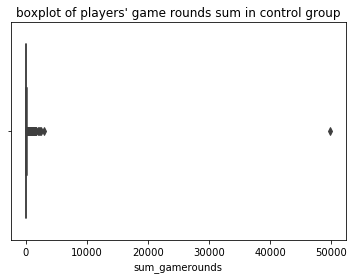

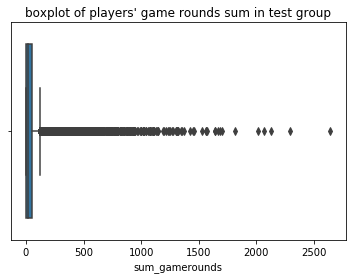

In [5]:
test=df[df.version=="gate_40"]
control=df[df.version=="gate_30"]
sns.boxplot(control.sum_gamerounds)
plt.title("boxplot of players' game rounds sum in control group")
plt.show()

sns.boxplot(test.sum_gamerounds)
plt.title("boxplot of players' game rounds sum in test group")
plt.show()

Here we can see, there is a outlier in the control group. This player played nearly 50000 rounds during the first week. Therefore the lower boxplot is heavily skewed and not informative.

Therefore, we need to check the statistical metrics of data from both groups and frequency of each sum_gamerounds

In [6]:
test.sum_gamerounds.describe()

count    45489.000000
mean        51.298776
std        103.294416
min          0.000000
25%          5.000000
50%         16.000000
75%         52.000000
max       2640.000000
Name: sum_gamerounds, dtype: float64

In [7]:
control.sum_gamerounds.describe()

count    44700.000000
mean        52.456264
std        256.716423
min          0.000000
25%          5.000000
50%         17.000000
75%         50.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

In [8]:
print("99 percentail of the sum_gamerounds: ",np.percentile(df.sum_gamerounds,99))
print("90 percentail of the sum_gamerounds: ",np.percentile(df.sum_gamerounds,90))

99 percentail of the sum_gamerounds:  493.0
90 percentail of the sum_gamerounds:  134.0


Text(0.5, 1.0, 'The number of players that played 0 - 150 game rounds during the first week ')

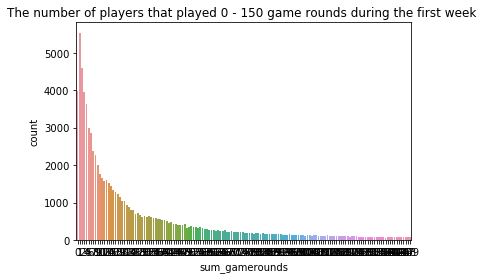

In [9]:
sns.countplot(df[df['sum_gamerounds']<150].sum_gamerounds)
plt.title("The number of players that played 0 - 150 game rounds during the first week ")

In [10]:

count = df.groupby('sum_gamerounds')['userid'].count()
count

sum_gamerounds
0        3994
1        5538
2        4606
3        3958
4        3629
         ... 
2294        1
2438        1
2640        1
2961        1
49854       1
Name: userid, Length: 942, dtype: int64

From the information above, we can get the information and possible reasons below：
### Information 1
  + Nearly 4000 players didn't even play a single round after installations:
#### Possible reasons:
  + They haven't playing the game after installing it.
  + The loading page/ interface design/ music and sound/ theme is not what players want, so they leave the game before playing the game.
  + The game is not as good as they see in the promotional video.

  
### Information 2
   + A quarter of players (around 22000 players) only played 5 levels during the first week after installing the game.
   + Around 14000 players played fewer than three rounds.
#### Possible reasons:
   + They used up the health points in the first few rounds. After quitting the game and wait for their health points to recover, they never open the game again.(The game is too hard to play)
   + The level settings is too easy or unattractive, so that players were easy to get bored.
   + They did not enjoy the game (under expectation, don't like puzzle games)
   
   
### Information 3 
  + Less one percent of players have played more than 500 rounds.
  + Over 90% of players are concentrated in 0-150 rounds
#### Possible reasons:
  + There may be professional players or game reviewers,and the game company can explore potential partnerships.
  + There may be users with highly stickiness that keep buying game props.

# 3 Comparing 1-day Retention

Retention rate is the common metric to measure how fun and engaging a game is.

The definition of 1-day retention: the percentage of players that comes back and plays the game one day after they have installed it.

In [11]:
print("The 1-day retention rate of the game: ",df.retention_1.sum()/df.retention_1.count())
test1=test.retention_1.sum()/test.retention_1.count()
control1=control.retention_1.sum()/control.retention_1.count()
print("The 1-day retention rate of the test group (gate_40): ",test1)
print("The 1-day retention rate of the control group (gate_30): ",control1)
print("1-day retention difference of A/B group: ",abs(test1-control1))

The 1-day retention rate of the game:  0.4452095044850259
The 1-day retention rate of the test group (gate_40):  0.44228274967574577
The 1-day retention rate of the control group (gate_30):  0.4481879194630872
1-day retention difference of A/B group:  0.005905169787341458


The retention rate of test group and control group is showed above. 

We can find out that there is a slight decrease in 1-day retention rate when the gate was moved from 30(44.22%) to 40(44.82%)

  
However, it doesn't mean that a gate at 40 level will be worse in the future.
Here we use bootstrapping to reapeatedly resample our dataset with replacement and calculate 1-day retention for those samples. By observing the variation in 1-day retention, we can have a indication of how uncertain the retention numbers are.

### Therefore, the hypothesis would be:
- Null Hypothesis: There is no difference between the control and experiment group.
  + The retention rates are same in both groups.
  + There is no statistical significant result.
  
- Alternate Hypothesis: There is difference between the control and experiment group.
  + Retention rates are different in both groups.
  + It shows a statistical significant.

To avoid Type I/Type II error, we need to make sure the sample size is large enough,and the significance level must be specified while calculating the sample size.
Baseline Concersion rate：45%

Minimum Detectable Effect: 5%

Significance level:5%

Statistical power: 80%

sample size: 1550

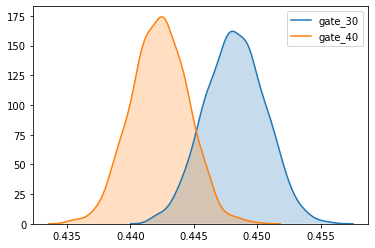

In [12]:
#define a function to get the mean of resampled dataset
def boot(size,dataset):
    resample=[]
    for i in range(size):
        boot_mean=df.sample(frac = 1,replace = True).groupby('version').retention_1.mean()
        resample.append(boot_mean)
    return resample

#sampling in size of 150 of resampling, do resample with df

boot_1d=pd.DataFrame(boot(1550,df))

sns.kdeplot(boot_1d.gate_30,shade=True)
sns.kdeplot(boot_1d.gate_40,shade=True)

The two distribution represents the bootstrap uncertainty over the 1-day retention of A/B groups. And we can observe difference between two groups.

Here we need to calculate AB group percent difference to see which group has he higher possibility to show a greater 1-day retention.
  


The possibility that 1-day retension is greater when gate is at level 30:  96.77 %


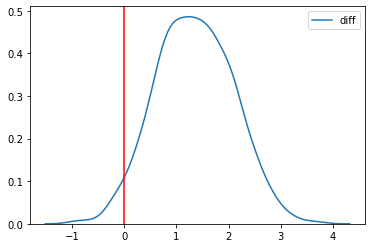

In [13]:
boot_1d["diff"]=100* (boot_1d.gate_30-boot_1d.gate_40)/boot_1d.gate_40

sns.kdeplot(boot_1d['diff'] )
plt.axvline(x=0,c='r')
print("The possibility that 1-day retension is greater when gate is at level 30: " ,round(100*((boot_1d['diff']>0).mean()),2),"%")

The most likely difference is around 0.5% to 2%, and 96.77% of the distribution is above 0, which shows a better retention rate of a gate at level 30

## T-test

In [23]:
retension1_30 = control.retention_1.sum()
retension1_40 = test.retention_1.sum()
n1_30=len(control)
n1_40=len(test)
print("retension_30: ",retension1_30)
print("retension_40: ",retension1_40)
print("n_40: ",n1_40)
print("n_30: ",n1_30)

retension_30:  20034
retension_40:  20119
n_40:  45489
n_30:  44700


In [26]:
z_score, p_value = sm.stats.proportions_ztest([retension1_40,retension1_30],[n1_40, n1_30],alternative='larger')
print("z_score: ",z_score)
print("p_value: ",p_value)

z_score:  -1.7840862247974725
p_value:  0.9627951723515404


According to the z_score and p_value,there was not a significant difference between the 1-day retention of control group and treatment group.

# 4 Comparing 7-day Retention

By applying bootstrap analysis, we understand that there is a high probaility that 1-day retention is better when the gate is at level 30. However, players may not able to reach level 30 in one day, which means there is still possibitlity that the 1-day retention haven't affected by the gate, no matter 30 or 40.
Therefore, there is still a need to look at 7-day retention as we assume more players should have reached level 40 after having played for a week.

In [177]:
print("The 7-day retention rate of the game: ",df.retention_7.sum()/df.retention_7.count())
test7=test['retention_7'].sum()/test['retention_7'].count()
control7=control.retention_7.sum()/control.retention_7.count()
print("The 7-day retention rate of the test group (gate_40): ",test7)
print("The 7-day retention rate of the control group (gate_30): ",control7)
print("7-day retention difference of A/B group: ",abs(test7-control7))

The 7-day retention rate of the game:  0.1860648194347426
The 7-day retention rate of the test group (gate_40):  0.18200004396667327
The 7-day retention rate of the control group (gate_30):  0.19020134228187918
7-day retention difference of A/B group:  0.008201298315205913


We can easily understand that:
    - The overall 7-day retention rate is lower than 1-day retention rate: it may affected by decreaing user activity and increasing churn.
    
    - The difference between test group and control group has increased (from 0.0059 to 0.0082)
    
    - Like with 1-day retention, 7-day retention is slightly lower when gate is at level 40(18.2%) than the gate is at level 30(19%).
    
As before, We still use the same approach - bootstrap analysis to figure out the difference between AB groups with high possibility.

Baseline Concersion rate：18%

Minimum Detectable Effect: 5%

Significance level:5%

sample size: 1000

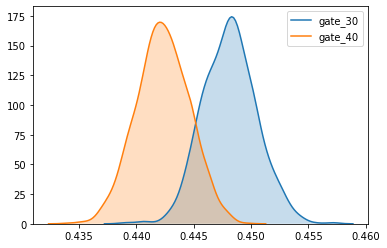

In [178]:
boot_7d=pd.DataFrame(boot(1000,df))
sns.kdeplot(boot_1d.gate_30,shade=True)
sns.kdeplot(boot_1d.gate_40,shade=True)

The two distribution represents the bootstrap uncertainty over the 7-day retention of A/B groups. And we can observe difference between two groups.

Here we need to calculate AB group percent difference to see which group has he higher possibility to show a greater 7-day retention.
  

The possibility that 7-day retension is greater when gate is at level 30:  95.3 %


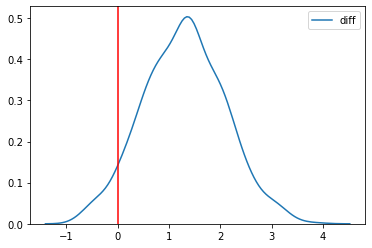

In [179]:
boot_7d["diff"]=100* (boot_7d.gate_30-boot_7d.gate_40)/boot_7d.gate_40

sns.kdeplot(boot_7d['diff'] )
plt.axvline(x=0,c='r')
print("The proportion that 7-day retension is greater when gate is at level 30: " ,round(100*((boot_7d['diff']>0).mean()),2),"%")

The most likely difference is around 1% to 2%, and 96.4% of the distribution is above 0%, which shows a better retention rate of a gate at level 30 then when it is at level 40.

In [24]:
retension7_30 = control.retention_7.sum()
retension7_40 = test.retention_7.sum()
n7_30=len(control)
n7_40=len(test)
print("retension_30: ",retension7_30)
print("retension_40: ",retension7_40)
print("n_40: ",n7_40)
print("n_30: ",n7_30)

retension_30:  8502
retension_40:  8279
n_40:  45489
n_30:  44700


In [27]:
z_score, p_value = sm.stats.proportions_ztest([retension7_40,retension7_30],[n7_40, n7_30],alternative='larger')
print("z_score: ",z_score)
print("p_value: ",p_value)

z_score:  -3.164358912748191
p_value:  0.9992228750121929


According to the z_score and p_value,there was not a significant difference between the 7-day retention of control group and treatment group.

# 5 Conclusion
In the bootstrap analysis, both 1-day retention and 7-day retention is higher when the gate is at level 30 than when it is at level 40. And there is no statistics significance to rejcet the null hypothesis.  We can make a conclusion that:

### In this case, we shouldn't move the gate from level 30 to level 40.

Also, as the metrics in dataset is limited, we also need to consider the metrics like:

- Active users weekly
- In-game purchase
- Weekly churn rate

to make this decision: whether to move the gate from level 30 to level 40.